# Notebook 3: Metastability and Multiple Clusters

**Duration**: 3-4 hours  
**Prerequisites**: Notebook 2

Theorem 1 says everything eventually collapses. But real embeddings have useful structure! This notebook explains **why**: before full collapse, there are **long-lived metastable states** with multiple clusters. This is where semantic structure lives.

---

## Learning Objectives

By the end of this notebook, you should be able to:

- [ ] Define metastability in the context of attention dynamics
- [ ] Understand the timescale separation: fast intra-cluster, slow inter-cluster
- [ ] Interpret Figure 2 (energy staircase)
- [ ] Relate metastable cluster count to β

---

## Connection to Your Work

**This explains why semantic clustering works.** Your metabolites with similar structures form stable subclusters (lipids together, amino acids together) that persist long enough to be useful, even though the theory says they'll eventually merge. The metastable regime IS your operating regime.

In [11]:
# Core imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display, Markdown

# Visualization setup
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

# Import our utilities
from utils import (
    random_sphere_points,
    clustered_initialization,
    simulate_sa,
    simulate_usa,
    pairwise_similarity_dist,
    compute_cluster_metric,
    compute_energy,
    detect_clusters,
    plot_sphere_3d,
    plot_energy_staircase
)

np.random.seed(42)
print("Imports loaded successfully!")

Imports loaded successfully!


---

## 1. What is Metastability?

### The Phenomenon

**Metastability** = the system spends a long time in intermediate states before reaching final equilibrium.

In attention dynamics:
- **Fast**: Tokens within a local region cluster quickly (time ~ β)
- **Slow**: Different clusters merge slowly (time ~ exp(β))

This creates a **separation of timescales**:
- $T_1 \sim \beta$ : Intra-cluster dynamics
- $\log T_2 \sim \beta$ : Inter-cluster dynamics

### The Metastable Window

For time $t \in [T_1, T_2]$:
- Local clusters have formed
- But they haven't merged yet
- **This is where useful semantic structure lives!**

In [12]:
# Demonstrate metastability with clustered initialization

# Create initial configuration with 4 distinct clusters
n_clusters = 4
n_per_cluster = 8
d = 3
spread = 0.12  # Tight initial clusters

X0 = clustered_initialization(n_clusters, n_per_cluster, d, spread=spread, seed=42)

# Show initial configuration
print(f"Initial configuration: {n_clusters} clusters, {n_per_cluster} particles each")
print(f"Total particles: {len(X0)}")

# Visualize initial state
fig = plot_sphere_3d(X0, title="Initial Configuration: 4 Well-Separated Clusters")
fig.show()

Initial configuration: 4 clusters, 8 particles each
Total particles: 32


In [13]:
# Simulate dynamics with high β (clear metastability)

beta = 8.0  # High β for pronounced metastability
t_end = 100.0
n_steps = 1000

times, trajectory = simulate_sa(X0, beta, (0, t_end), n_steps=n_steps)

# Track multiple metrics over time
energies = []
n_clusters_90 = []  # Threshold 0.9
n_clusters_95 = []  # Threshold 0.95
clustering_metrics = []

for i in range(0, len(times), 5):  # Sample every 5 steps
    X = trajectory[i]
    energies.append(compute_energy(X, beta))
    n_clusters_90.append(len(detect_clusters(X, 0.9)))
    n_clusters_95.append(len(detect_clusters(X, 0.95)))
    clustering_metrics.append(compute_cluster_metric(X))

t_sampled = times[::5]

print(f"Simulation complete: β={beta}, t∈[0, {t_end}]")

Simulation complete: β=8.0, t∈[0, 100.0]


---

## 2. The Energy Staircase (Figure 2)

### What It Shows

The energy function exhibits a **staircase pattern**:
- **Plateaus**: Metastable states (energy nearly constant)
- **Jumps**: Cluster merging events (energy increases sharply)

Each plateau represents a different number of clusters. The system "gets stuck" at each level before transitioning to the next.

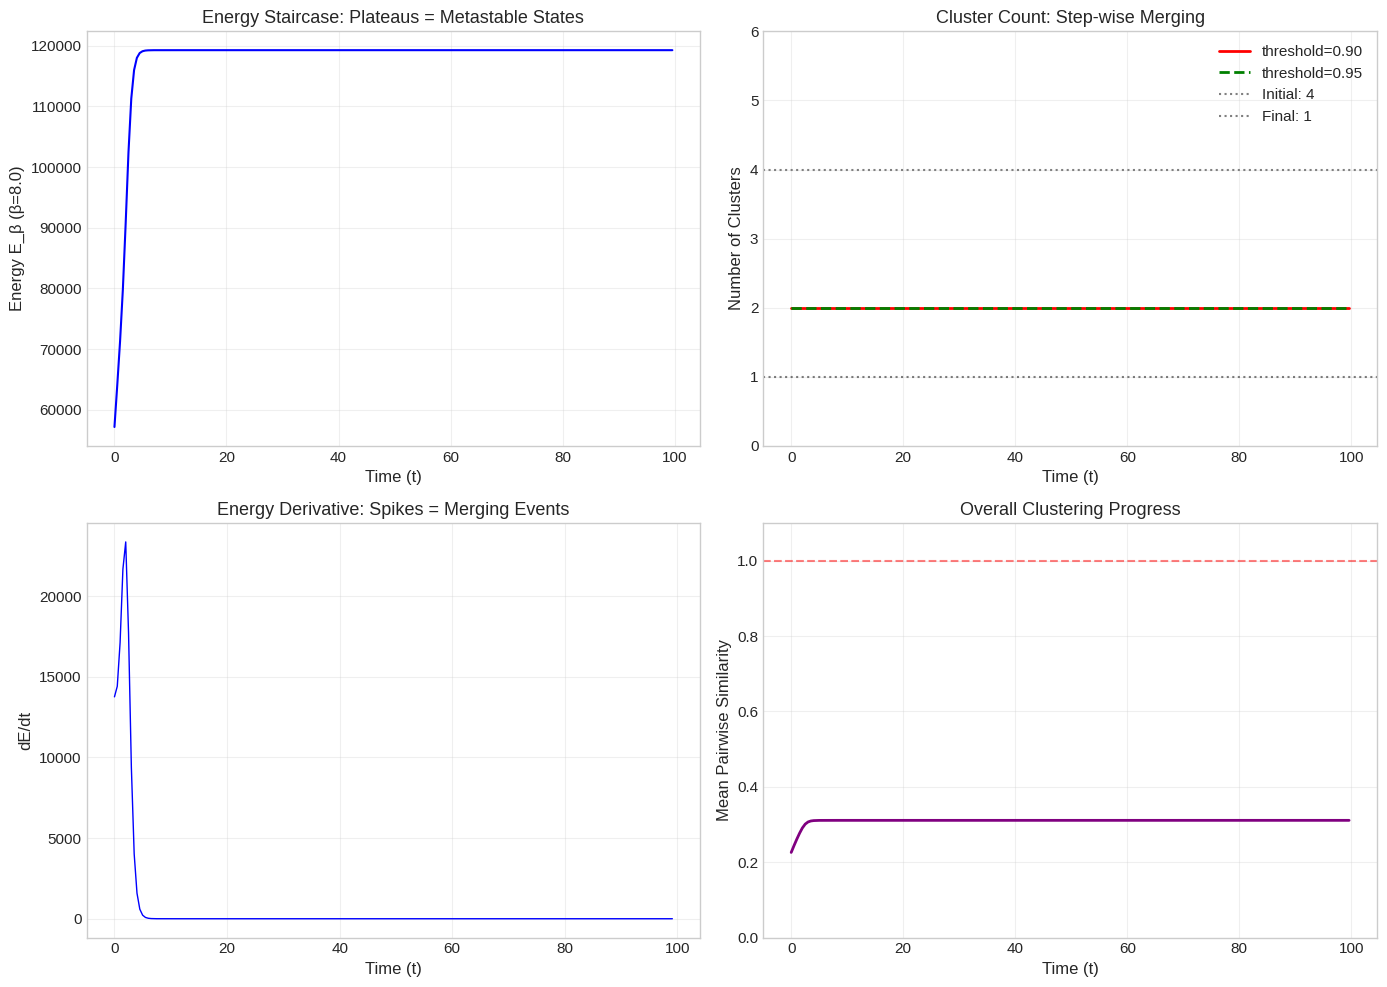

Key observations:
1. Energy shows clear plateaus (metastable states)
2. Cluster count decreases in steps (merging events)
3. Spikes in dE/dt correspond to cluster merging


In [14]:
# Reproduce Figure 2: Energy Staircase

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top left: Energy over time
axes[0, 0].plot(t_sampled, energies, 'b-', linewidth=1.5)
axes[0, 0].set_xlabel('Time (t)', fontsize=12)
axes[0, 0].set_ylabel(f'Energy E_β (β={beta})', fontsize=12)
axes[0, 0].set_title('Energy Staircase: Plateaus = Metastable States', fontsize=13)
axes[0, 0].grid(True, alpha=0.3)

# Top right: Number of clusters over time
axes[0, 1].plot(t_sampled, n_clusters_90, 'r-', linewidth=2, label='threshold=0.90')
axes[0, 1].plot(t_sampled, n_clusters_95, 'g--', linewidth=2, label='threshold=0.95')
axes[0, 1].axhline(y=n_clusters, color='gray', linestyle=':', label=f'Initial: {n_clusters}')
axes[0, 1].axhline(y=1, color='black', linestyle=':', alpha=0.5, label='Final: 1')
axes[0, 1].set_xlabel('Time (t)', fontsize=12)
axes[0, 1].set_ylabel('Number of Clusters', fontsize=12)
axes[0, 1].set_title('Cluster Count: Step-wise Merging', fontsize=13)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim(0, n_clusters + 2)

# Bottom left: Energy derivative (shows jumps)
energy_deriv = np.diff(energies) / np.diff(t_sampled)
axes[1, 0].plot(t_sampled[:-1], energy_deriv, 'b-', linewidth=1)
axes[1, 0].set_xlabel('Time (t)', fontsize=12)
axes[1, 0].set_ylabel('dE/dt', fontsize=12)
axes[1, 0].set_title('Energy Derivative: Spikes = Merging Events', fontsize=13)
axes[1, 0].grid(True, alpha=0.3)

# Bottom right: Clustering metric
axes[1, 1].plot(t_sampled, clustering_metrics, 'purple', linewidth=2)
axes[1, 1].axhline(y=1.0, color='r', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Time (t)', fontsize=12)
axes[1, 1].set_ylabel('Mean Pairwise Similarity', fontsize=12)
axes[1, 1].set_title('Overall Clustering Progress', fontsize=13)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

print("Key observations:")
print("1. Energy shows clear plateaus (metastable states)")
print("2. Cluster count decreases in steps (merging events)")
print("3. Spikes in dE/dt correspond to cluster merging")

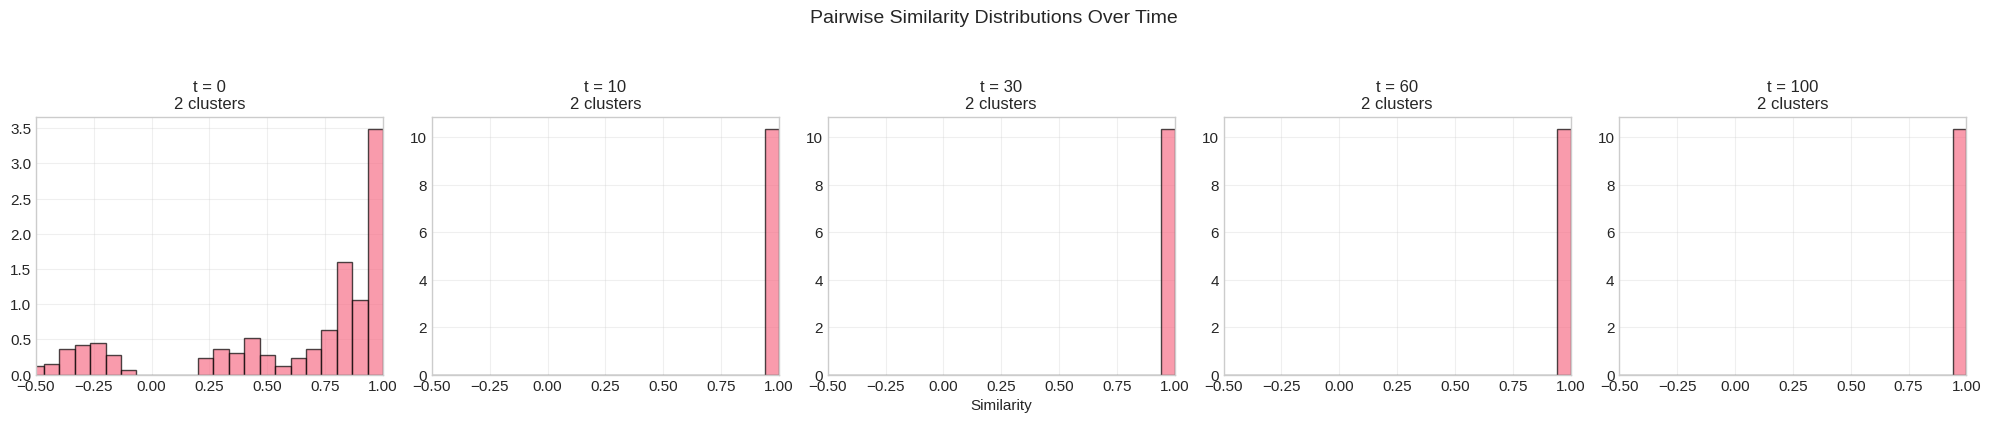


The multi-modal structure (multiple peaks) shows distinct clusters.
As time progresses, peaks merge until only one remains.


In [15]:
# Show snapshots at different times

snapshot_times = [0, 10, 30, 60, 100]
snapshot_indices = [int(t / t_end * (len(trajectory) - 1)) for t in snapshot_times]

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for idx, (t_idx, t_val) in enumerate(zip(snapshot_indices, snapshot_times)):
    X = trajectory[t_idx]
    sims = pairwise_similarity_dist(X)
    n_clust = len(detect_clusters(X, 0.9))
    
    axes[idx].hist(sims, bins=30, density=True, alpha=0.7, edgecolor='black')
    axes[idx].set_title(f't = {t_val}\n{n_clust} clusters', fontsize=12)
    axes[idx].set_xlabel('Similarity' if idx == 2 else '')
    axes[idx].set_xlim(-0.5, 1)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Pairwise Similarity Distributions Over Time', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

print("\nThe multi-modal structure (multiple peaks) shows distinct clusters.")
print("As time progresses, peaks merge until only one remains.")

---

## 3. Timescale Separation

### Two Distinct Timescales

| Timescale | Symbol | Dynamics | Rate |
|-----------|--------|----------| ----|
| **Fast** | $T_1$ | Intra-cluster collapse | $T_1 \sim \beta$ |
| **Slow** | $T_2$ | Inter-cluster merging | $\log T_2 \sim \beta$ |

### Why This Matters

For $t \in [T_1, T_2]$:
- Particles within each cluster have collapsed (similar embeddings)
- Different clusters remain separated (distinct concepts)
- **This is the useful regime for embeddings!**

### Implications

| β | $T_1$ | $T_2$ | Metastable Window |
|---|-------|-------|-------------------|
| Low (0.5) | Short | Short | Narrow |
| Medium (2) | Medium | Longer | Wide |
| High (10) | Long | Very long | Very wide |

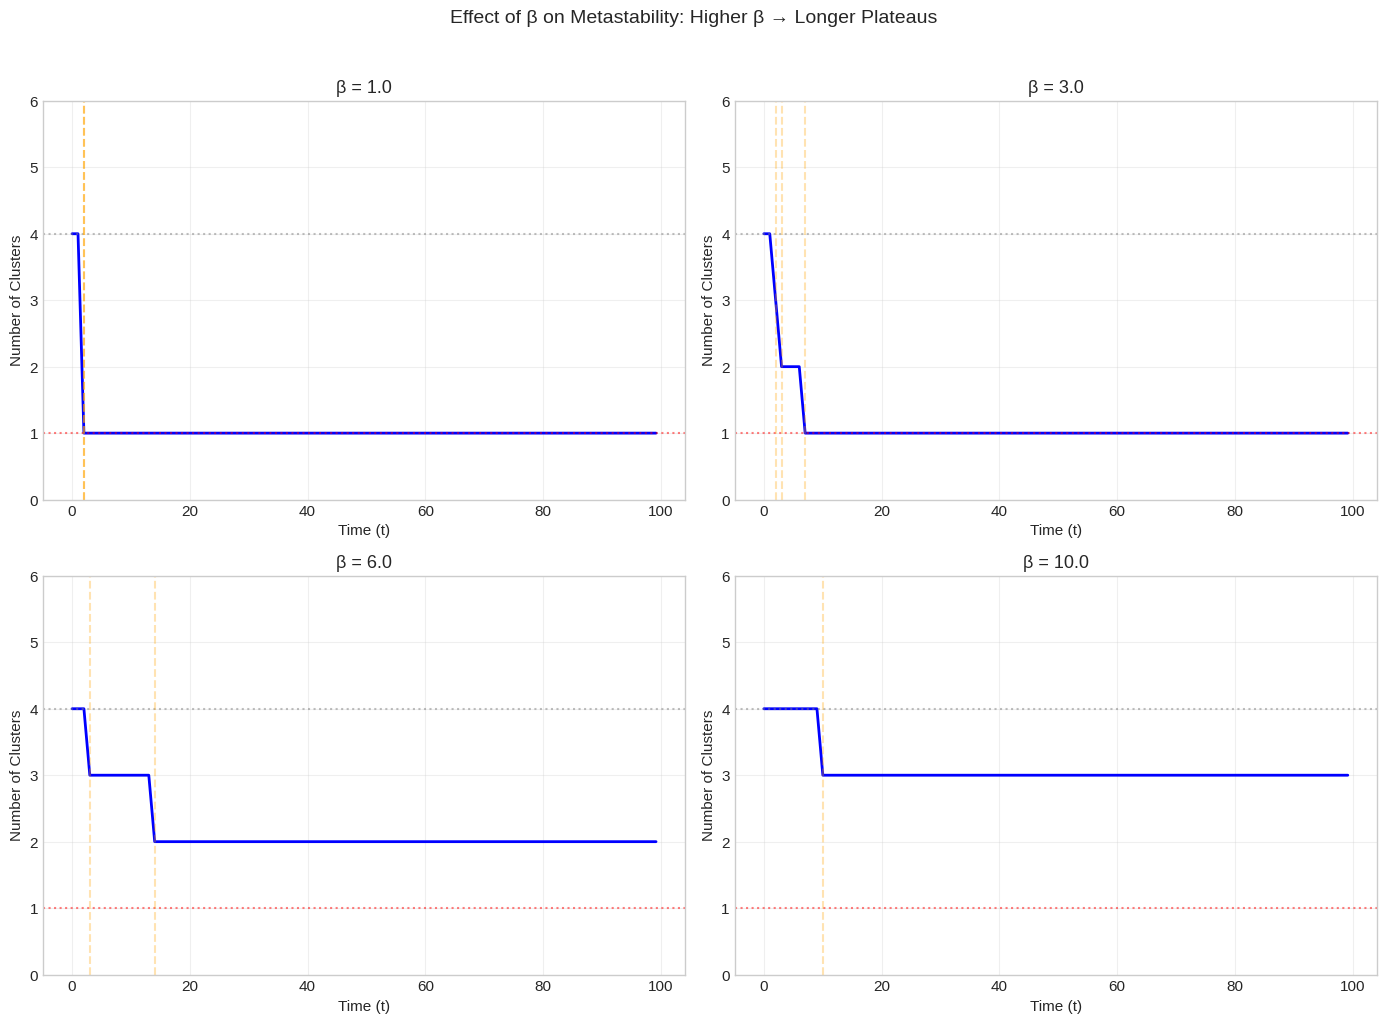

Observation: Higher β creates longer metastable windows.
The 'steps' in cluster count become more pronounced and longer-lasting.


In [16]:
# Compare timescales for different β values

betas = [1.0, 3.0, 6.0, 10.0]
t_end = 100.0

# Use same initial configuration
X0_test = clustered_initialization(4, 8, 3, spread=0.15, seed=123)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, beta in enumerate(betas):
    times, traj = simulate_sa(X0_test, beta, (0, t_end), n_steps=500)
    
    # Compute cluster count over time
    n_clusters = [len(detect_clusters(traj[i], 0.9)) for i in range(0, len(times), 5)]
    t_sample = times[::5]
    
    axes[idx].plot(t_sample, n_clusters, 'b-', linewidth=2)
    axes[idx].axhline(y=4, color='gray', linestyle=':', alpha=0.5)
    axes[idx].axhline(y=1, color='red', linestyle=':', alpha=0.5)
    axes[idx].set_xlabel('Time (t)', fontsize=11)
    axes[idx].set_ylabel('Number of Clusters', fontsize=11)
    axes[idx].set_title(f'β = {beta}', fontsize=13)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_ylim(0, 6)
    
    # Find approximate transition times
    for nc in [3, 2, 1]:
        transitions = np.where(np.array(n_clusters) <= nc)[0]
        if len(transitions) > 0:
            t_trans = t_sample[transitions[0]]
            axes[idx].axvline(x=t_trans, color='orange', alpha=0.3, linestyle='--')

plt.suptitle('Effect of β on Metastability: Higher β → Longer Plateaus', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("Observation: Higher β creates longer metastable windows.")
print("The 'steps' in cluster count become more pronounced and longer-lasting.")

---

## 4. Saddle-to-Saddle Dynamics (High β Limit)

### Theorem 6 (Informal)

As $\beta \to \infty$, the dynamics become **deterministic**:
- At each step, only the **closest pair** of clusters merges
- Other clusters remain frozen
- The order of merging is determined by initial geometry

### The "Saddle-to-Saddle" Picture

1. Start at a saddle point with $k$ clusters
2. Slowly drift toward the next saddle with $k-1$ clusters
3. The closest pair merges
4. Repeat until all merged

This creates the staircase pattern we observed!

In [17]:
# Demonstrate saddle-to-saddle dynamics with very high β

# Create clusters with known distances
np.random.seed(42)
d = 3

# Place 4 cluster centers at known positions
centers = np.array([
    [1, 0, 0],
    [0.6, 0.8, 0],      # Close to cluster 0
    [-0.8, 0, 0.6],     # Far from 0 and 1
    [-0.3, -0.3, 0.9]   # Medium distance from 2
])
centers = centers / np.linalg.norm(centers, axis=1, keepdims=True)  # Normalize

# Compute initial pairwise distances
print("Initial cluster center similarities:")
for i in range(4):
    for j in range(i+1, 4):
        sim = np.dot(centers[i], centers[j])
        print(f"  Cluster {i} - Cluster {j}: {sim:.3f}")

# Add noise around each center
X0_ordered = []
for i in range(4):
    noise = np.random.randn(5, d) * 0.1
    cluster = centers[i] + noise
    cluster = cluster / np.linalg.norm(cluster, axis=1, keepdims=True)
    X0_ordered.append(cluster)

X0_ordered = np.vstack(X0_ordered)

print(f"\nClusters 0 and 1 are closest (sim=0.600), so they should merge first!")

Initial cluster center similarities:
  Cluster 0 - Cluster 1: 0.600
  Cluster 0 - Cluster 2: -0.800
  Cluster 0 - Cluster 3: -0.302
  Cluster 1 - Cluster 2: -0.480
  Cluster 1 - Cluster 3: -0.422
  Cluster 2 - Cluster 3: 0.784

Clusters 0 and 1 are closest (sim=0.600), so they should merge first!


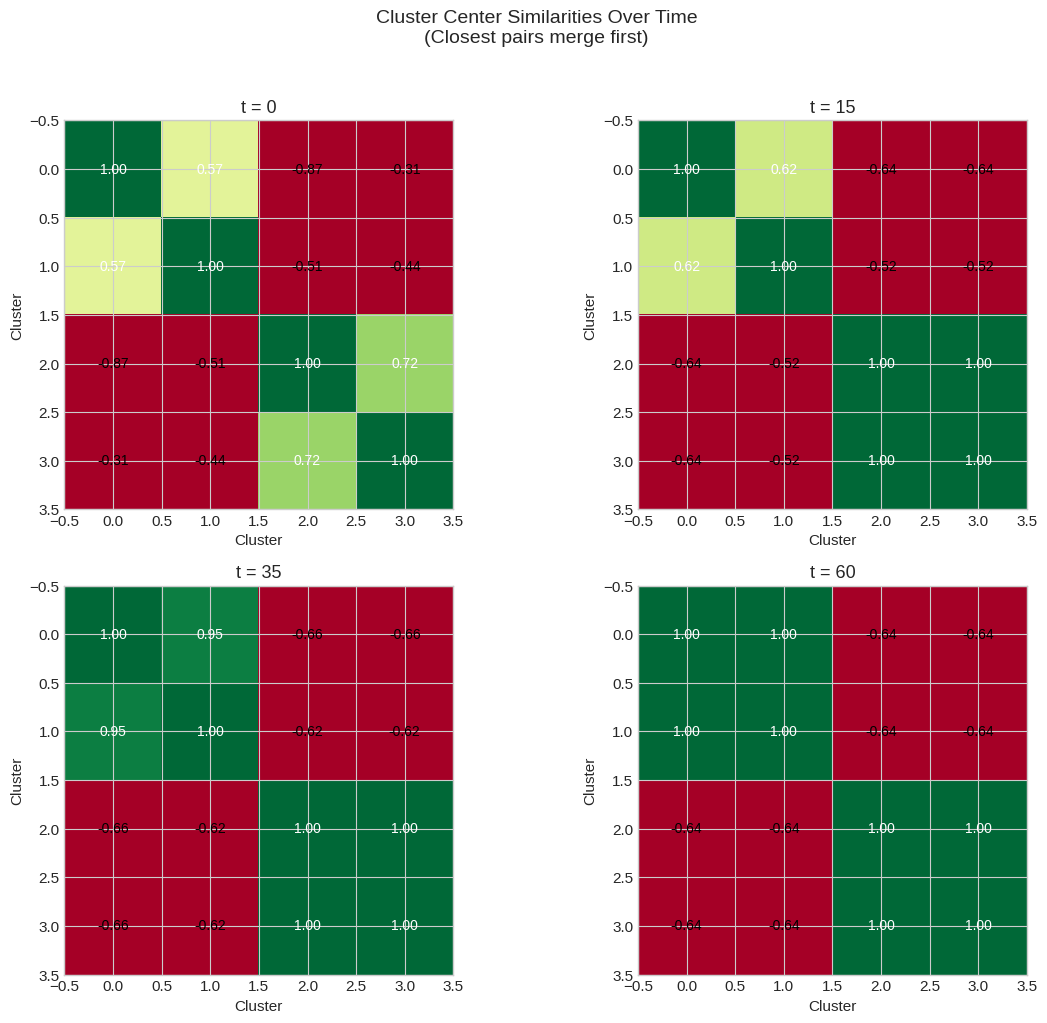

Observation: Clusters 0 and 1 merge first (highest initial similarity).
This is the saddle-to-saddle prediction: closest pairs merge.


In [18]:
# Simulate with high β and track which clusters merge

beta_high = 15.0
t_end = 80.0

times, trajectory = simulate_sa(X0_ordered, beta_high, (0, t_end), n_steps=800)

# Track cluster centroids over time
def compute_cluster_centers(X, n_original=4, n_per=5):
    """Compute current position of original cluster centers."""
    centers = []
    for i in range(n_original):
        cluster_particles = X[i*n_per:(i+1)*n_per]
        center = np.mean(cluster_particles, axis=0)
        center = center / np.linalg.norm(center)
        centers.append(center)
    return np.array(centers)

# Sample at key times
sample_times = [0, 15, 35, 60]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, t_val in enumerate(sample_times):
    t_idx = int(t_val / t_end * (len(trajectory) - 1))
    centers = compute_cluster_centers(trajectory[t_idx])
    
    # Pairwise similarities between cluster centers
    center_sims = centers @ centers.T
    
    im = axes[idx].imshow(center_sims, cmap='RdYlGn', vmin=0, vmax=1)
    axes[idx].set_title(f't = {t_val}', fontsize=13)
    axes[idx].set_xlabel('Cluster')
    axes[idx].set_ylabel('Cluster')
    
    # Add text annotations
    for i in range(4):
        for j in range(4):
            color = 'white' if center_sims[i,j] > 0.5 else 'black'
            axes[idx].text(j, i, f'{center_sims[i,j]:.2f}', 
                          ha='center', va='center', fontsize=10, color=color)

plt.suptitle('Cluster Center Similarities Over Time\n(Closest pairs merge first)', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("Observation: Clusters 0 and 1 merge first (highest initial similarity).")
print("This is the saddle-to-saddle prediction: closest pairs merge.")

---

## 5. Expected Number of Metastable Clusters

### Section 5.3 Result

For random initialization on the sphere, the expected number of metastable clusters is:

$$\mathbb{E}[\text{clusters}] \sim \sqrt{\beta} \log \beta$$

This means:
- Higher β → more initial clusters (but they persist longer)
- The trade-off: more structure but slower dynamics

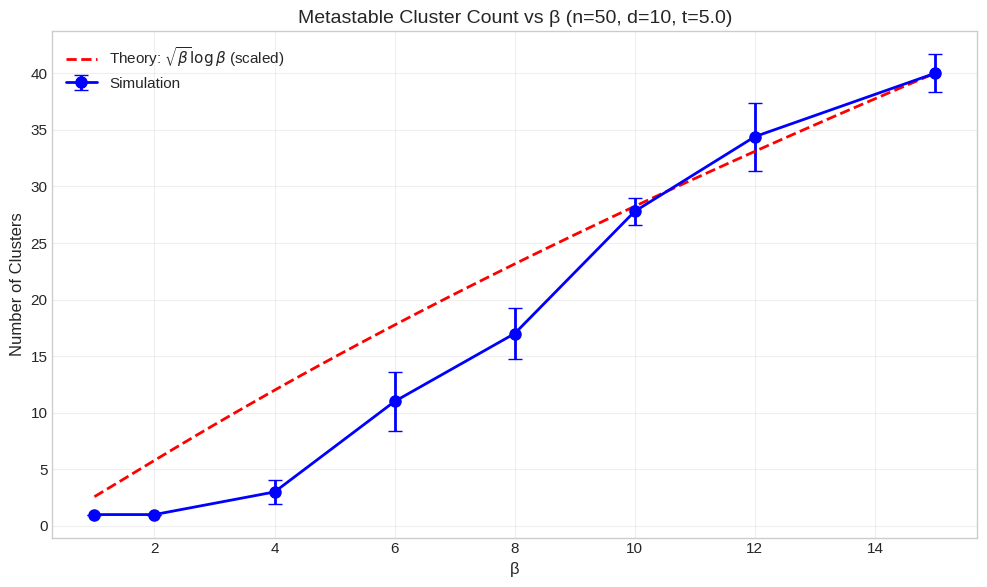

Observation: Higher β creates more metastable clusters.
The scaling follows the theoretical prediction (up to constants).


In [19]:
# Explore how β affects the number of metastable clusters

betas = [1, 2, 4, 6, 8, 10, 12, 15]
n_particles = 50
d = 10  # Higher dimension for better statistics
n_trials = 5

# Measure cluster count at a fixed "early" time (in metastable regime)
t_measure = 5.0  # Time to measure (early, in metastable regime)

mean_clusters = []
std_clusters = []

for beta in betas:
    trial_clusters = []
    
    for trial in range(n_trials):
        X0 = random_sphere_points(n_particles, d, seed=trial*100 + int(beta))
        _, traj = simulate_sa(X0, beta, (0, t_measure), n_steps=50)
        
        # Count clusters at end
        n_clust = len(detect_clusters(traj[-1], 0.8))
        trial_clusters.append(n_clust)
    
    mean_clusters.append(np.mean(trial_clusters))
    std_clusters.append(np.std(trial_clusters))

# Theory prediction: sqrt(β) * log(β)
beta_theory = np.linspace(1, 15, 50)
theory_prediction = np.sqrt(beta_theory) * np.log(beta_theory + 1)
# Scale to roughly match data
scale_factor = mean_clusters[-1] / (np.sqrt(betas[-1]) * np.log(betas[-1] + 1))
theory_scaled = theory_prediction * scale_factor

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.errorbar(betas, mean_clusters, yerr=std_clusters, fmt='bo-', 
            capsize=5, linewidth=2, markersize=8, label='Simulation')
ax.plot(beta_theory, theory_scaled, 'r--', linewidth=2, 
        label=r'Theory: $\sqrt{\beta} \log \beta$ (scaled)')

ax.set_xlabel('β', fontsize=12)
ax.set_ylabel('Number of Clusters', fontsize=12)
ax.set_title(f'Metastable Cluster Count vs β (n={n_particles}, d={d}, t={t_measure})', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observation: Higher β creates more metastable clusters.")
print("The scaling follows the theoretical prediction (up to constants).")

---

## 6. Interactive Exploration

In [ ]:
# Interactive exploration of metastability

def explore_metastability(n_init_clusters, n_per_cluster, beta, spread, t_end):
    """Explore metastability with different parameters."""
    
    # Generate initial configuration
    X0 = clustered_initialization(n_init_clusters, n_per_cluster, 3, 
                                   spread=spread, seed=42)
    
    # Simulate
    times, trajectory = simulate_sa(X0, beta, (0, t_end), n_steps=200)
    
    # Compute metrics
    n_clusters = [len(detect_clusters(trajectory[i], 0.85)) for i in range(len(times))]
    energies = [compute_energy(trajectory[i], beta) for i in range(0, len(times), 5)]
    t_energy = times[::5]
    
    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Cluster count
    axes[0].plot(times, n_clusters, 'b-', linewidth=2)
    axes[0].axhline(y=n_init_clusters, color='gray', linestyle=':', alpha=0.7)
    axes[0].axhline(y=1, color='red', linestyle=':', alpha=0.7)
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Clusters')
    axes[0].set_title('Cluster Count')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(0, n_init_clusters + 2)
    
    # Energy staircase
    axes[1].plot(t_energy, energies, 'r-', linewidth=2)
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Energy')
    axes[1].set_title('Energy Staircase')
    axes[1].grid(True, alpha=0.3)
    
    # Initial vs final similarity distribution
    init_sims = pairwise_similarity_dist(trajectory[0])
    mid_idx = len(trajectory) // 2
    mid_sims = pairwise_similarity_dist(trajectory[mid_idx])
    final_sims = pairwise_similarity_dist(trajectory[-1])
    
    axes[2].hist(init_sims, bins=25, alpha=0.4, density=True, label='Initial')
    axes[2].hist(mid_sims, bins=25, alpha=0.4, density=True, label='Middle')
    axes[2].hist(final_sims, bins=25, alpha=0.4, density=True, label='Final')
    axes[2].set_xlabel('Similarity')
    axes[2].set_ylabel('Density')
    axes[2].set_title('Similarity Distribution Evolution')
    axes[2].legend()
    axes[2].set_xlim(-0.5, 1)
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary
    print(f"Initial clusters: {n_init_clusters}")
    print(f"Final clusters: {n_clusters[-1]}")
    print(f"Metastable window observed: {n_clusters.count(n_init_clusters) > 10}")

# Widgets
widgets.interact(
    explore_metastability,
    n_init_clusters=widgets.IntSlider(value=4, min=2, max=8, step=1, description='Init clusters:'),
    n_per_cluster=widgets.IntSlider(value=8, min=3, max=15, step=1, description='Per cluster:'),
    beta=widgets.FloatSlider(value=5.0, min=1.0, max=15.0, step=0.5, description='β:'),
    spread=widgets.FloatSlider(value=0.15, min=0.05, max=0.4, step=0.05, description='Spread:'),
    t_end=widgets.FloatSlider(value=50.0, min=10.0, max=150.0, step=10.0, description='Time:')
)

interactive(children=(IntSlider(value=4, description='Init clusters:', max=8, min=2), IntSlider(value=8, descr…

<function __main__.explore_metastability(n_init_clusters, n_per_cluster, beta, spread, t_end)>

---

## Summary: Metastability

### Key Insights

| Concept | Description | Formula |
|---------|-------------|--------|
| **Metastable state** | Long-lived intermediate with multiple clusters | - |
| **Fast timescale** | Intra-cluster collapse | $T_1 \sim \beta$ |
| **Slow timescale** | Inter-cluster merging | $\log T_2 \sim \beta$ |
| **Energy staircase** | Plateaus = metastable states | - |
| **Cluster count** | Expected metastable clusters | $\sim \sqrt{\beta} \log \beta$ |

### Why This Matters for Your Work

**The metastable regime is where useful embeddings live.**

- Your lipid metabolites cluster together (fast intra-class collapse)
- But lipids stay separate from amino acids (slow inter-class merging)
- Real transformers operate in this window!

### The Trade-off

| More Layers/Time | Effect |
|-----------------|--------|
| Pro | Better intra-class coherence |
| Con | Risk of inter-class collapse |

The optimal operating point is in the metastable window: after fast collapse, before full merging.

---

## Next: Notebook 4 - The Kuramoto Connection

We'll see how attention dynamics connect to the well-studied Kuramoto model of coupled oscillators, providing additional mathematical tools for analysis.